## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# 1. Read Data

In [103]:
test = pd.read_csv('/kaggle/input/playground-series-s3e24/test.csv')
train = pd.read_csv('/kaggle/input/playground-series-s3e24/train.csv')

train.shape, test.shape

((159256, 24), (106171, 23))

In [3]:
test.head()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries
0,159256,40,165,70,84.0,1.2,1.2,1,1,130,...,186,49,115,14.2,1,0.9,19,25,32,0
1,159257,80,160,60,93.0,1.0,1.0,2,2,144,...,158,35,104,13.0,1,1.1,20,12,24,0
2,159258,60,170,70,86.5,0.6,0.7,1,1,117,...,173,39,88,15.4,1,1.4,38,60,36,0
3,159259,40,160,50,67.0,0.3,0.4,1,1,116,...,47,75,128,14.5,1,0.6,25,18,10,1
4,159260,40,170,75,89.4,1.0,0.9,1,1,132,...,100,39,123,16.5,1,1.0,30,39,27,1


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106171 entries, 0 to 106170
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   106171 non-null  int64  
 1   age                  106171 non-null  int64  
 2   height(cm)           106171 non-null  int64  
 3   weight(kg)           106171 non-null  int64  
 4   waist(cm)            106171 non-null  float64
 5   eyesight(left)       106171 non-null  float64
 6   eyesight(right)      106171 non-null  float64
 7   hearing(left)        106171 non-null  int64  
 8   hearing(right)       106171 non-null  int64  
 9   systolic             106171 non-null  int64  
 10  relaxation           106171 non-null  int64  
 11  fasting blood sugar  106171 non-null  int64  
 12  Cholesterol          106171 non-null  int64  
 13  triglyceride         106171 non-null  int64  
 14  HDL                  106171 non-null  int64  
 15  LDL              

# 2. EDA

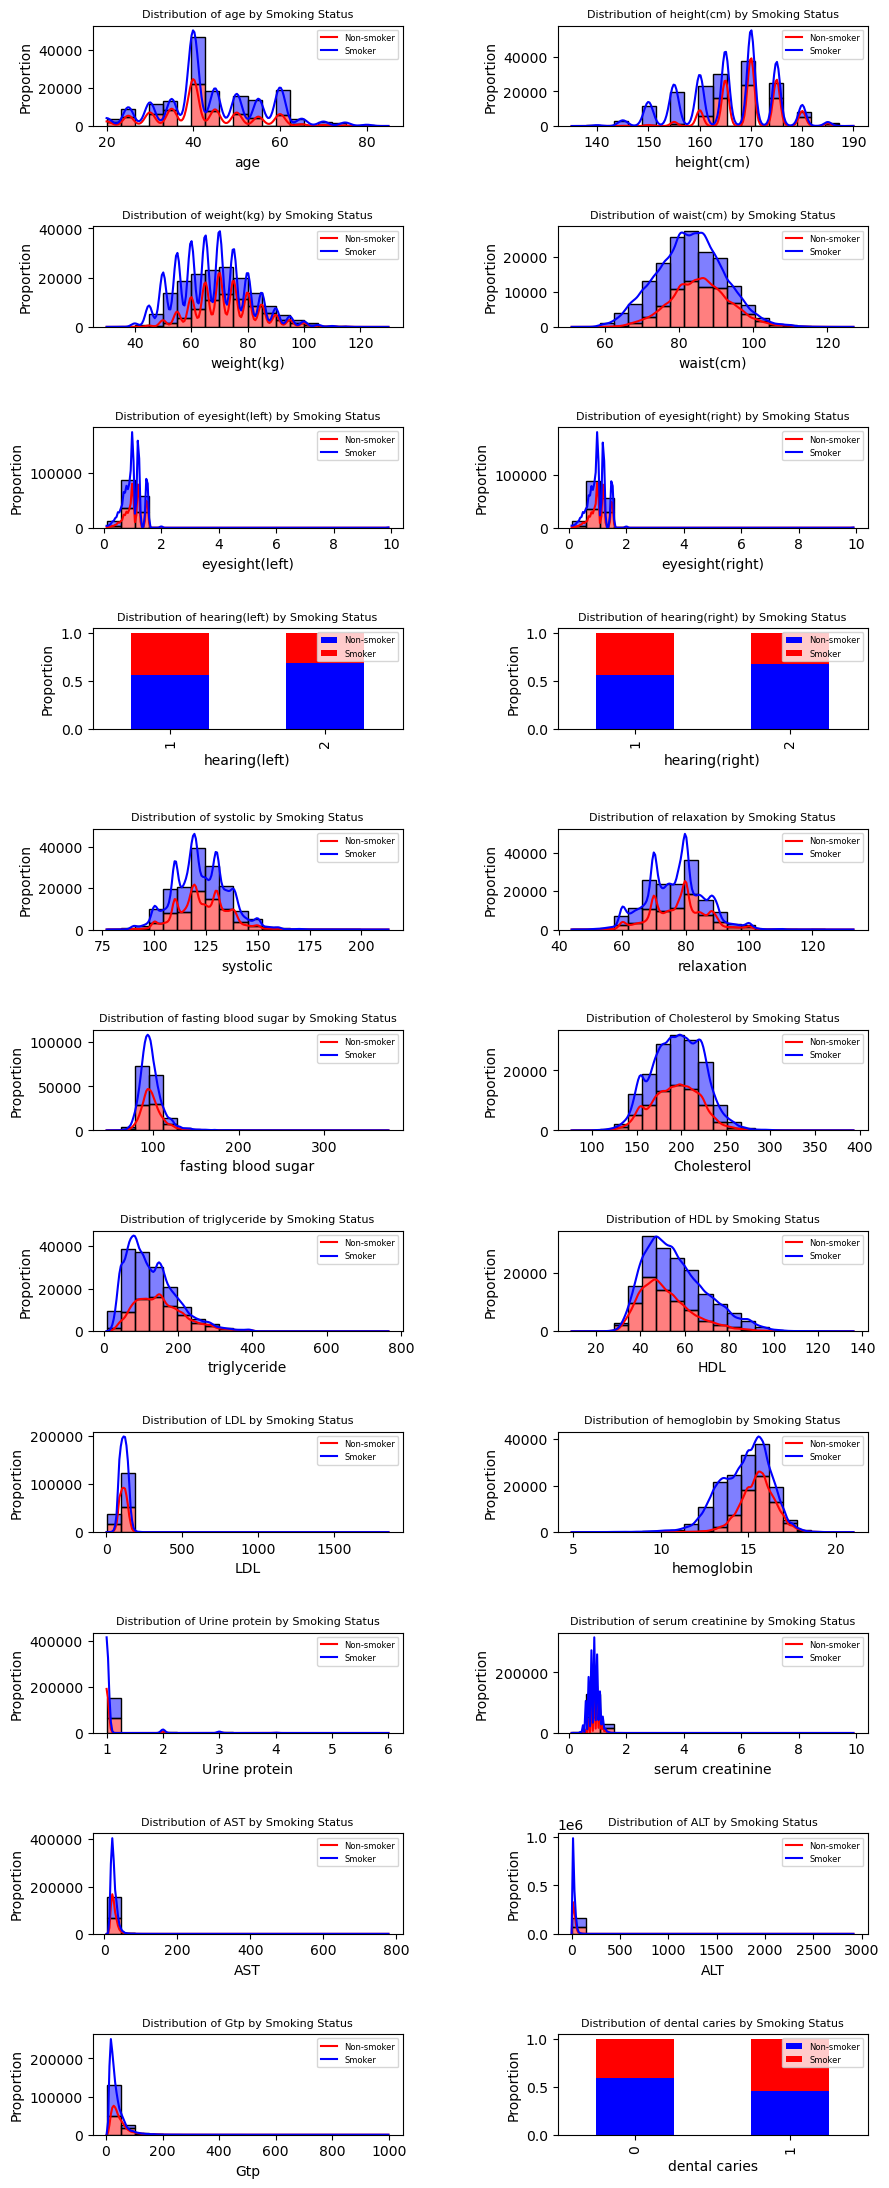

In [21]:
columns = list(train.columns)
columns = columns[1:]  # Exclude the 'id' column

# Determine the number of rows and columns for the subplots
n_features = len(columns)
n_cols = 2  # Two subplots per row
n_rows = (n_features + n_cols - 1) // n_cols  # Calculate the number of rows required


fig, axes = plt.subplots(12, 2, figsize=(10, 30))
fig.subplots_adjust(hspace=1, wspace=0.5)

# Iterate through the columns and their corresponding axes
for item, ax in zip(columns, axes.ravel()[:n_features]):
    # Create stacked bar chart for specific columns
    if item in ['hearing(left)', 'hearing(right)', 'dental caries']:
        cross_tab = pd.crosstab(train[item], train['smoking'], normalize='index')
        cross_tab.plot(kind='bar', stacked=True, ax=ax, color=['blue', 'red'])
    # Create histograms for non-'smoking' features
    elif item != 'smoking':
        sns.histplot(data=train, x=item, hue='smoking', palette=['blue', 'red'], multiple='stack', bins=20, kde=True, ax=ax)

    ax.set_title(f'Distribution of {item} by Smoking Status', fontsize=8)
    ax.set_xlabel(item, fontsize=10)
    ax.set_ylabel('Proportion', fontsize=10)
    ax.legend(labels=['Non-smoker', 'Smoker'], fontsize=6)

# Remove any extra empty subplots
for ax in axes.ravel()[n_features-1:]:
    fig.delaxes(ax)

plt.show()

### Correlation

Text(0.5, 1.0, 'Spearman Correlation Heatmap')

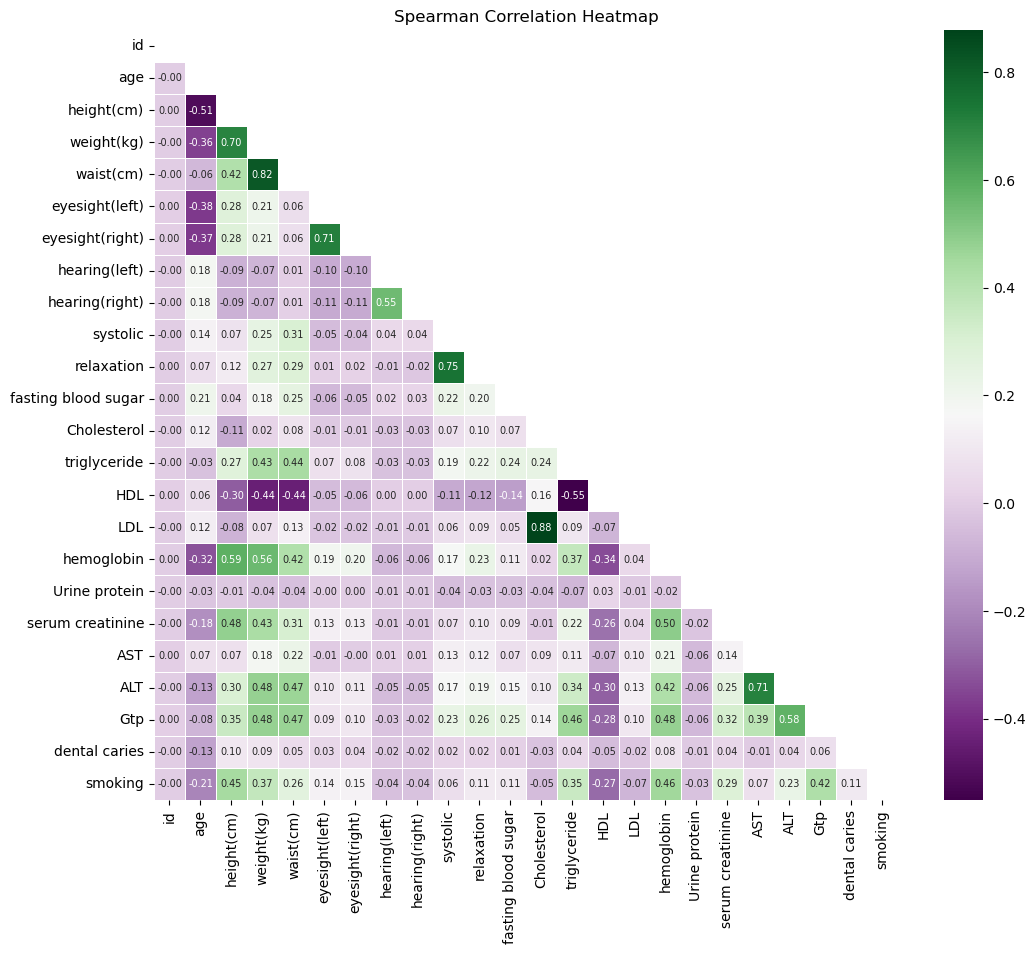

In [105]:
spearman_correlation = train.corr(method="spearman")
mask = np.triu(np.ones_like(spearman_correlation, dtype=bool)) # Create upper triangular mask to hide the repeated values in the heatmap

plt.figure(figsize=(12, 10))
sns.heatmap(spearman_correlation, annot=True, cmap="PRGn", fmt=".2f", linewidths=0.5, annot_kws={"size": 7}, mask=mask)
plt.title("Spearman Correlation Heatmap")

### Identify outliers

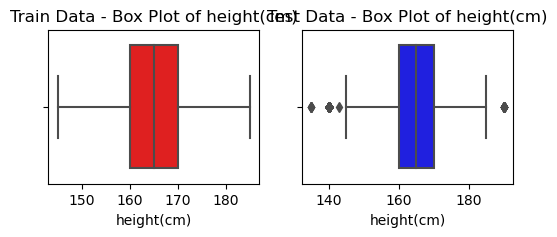

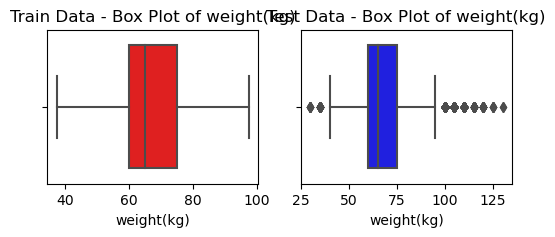

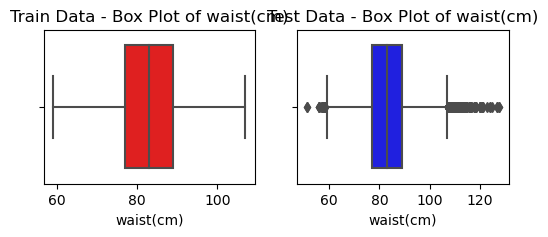

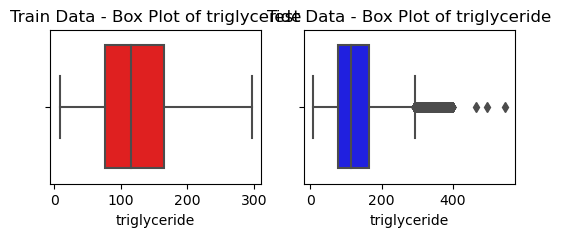

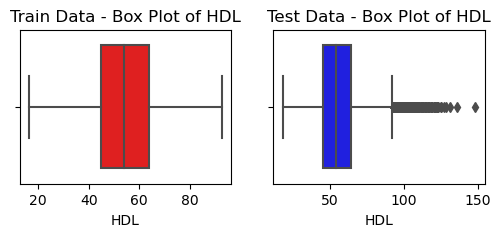

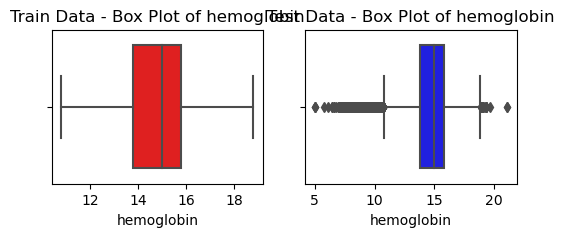

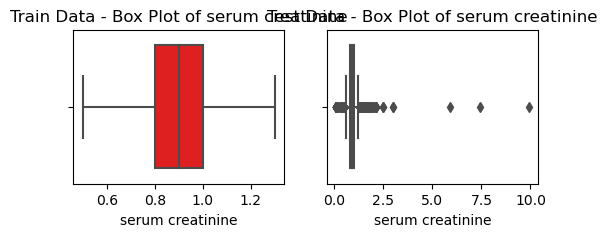

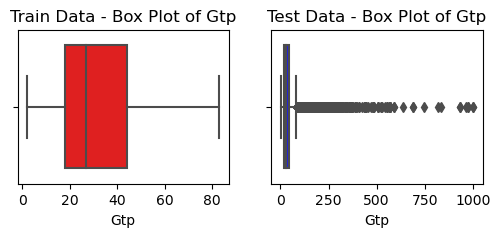

In [101]:
features = train.columns.drop(['id', 'smoking']).tolist()

for feature in features:
    plt.figure(figsize=(6,2))
    plt.subplot(1,2,1)
    sns.boxplot(x=train[feature], color='red')
    plt.title(f'Train Data - Box Plot of {feature}')
    
    plt.subplot(1, 2, 2)
    sns.boxplot(x=test[feature], color='blue')
    plt.title(f'Test Data - Box Plot of {feature}')
    plt.show()

In [31]:
outlier_cols = ['height(cm)','weight(kg)','waist(cm)','systolic','relaxation','fasting blood sugar','Cholesterol',
 'triglyceride','LDL','hemoglobin','HDL','serum creatinine','AST','ALT','Gtp']

### Removing outliers

In [30]:
def outlier_handler(df,col):
  # Calculate the 25th and 75th percentiles of the column
  percentile25 = df[col].quantile(0.25)
  percentile75 = df[col].quantile(0.75)

  iqr = percentile75 - percentile25 # Calculate the Interquartile Range (IQR)

  # Define the upper and lower limits for identifying outliers
  upper_limit = percentile75 + 1.5 * iqr
  lower_limit = percentile25 - 1.5 * iqr

  # Replace values exceeding the upper or lower limits with the limits themselves
  df.loc[df[col] > upper_limit,col] = upper_limit
  df.loc[df[col] < lower_limit,col] = lower_limit

  return df

In [34]:
for col1 in train.columns:
  if col1 in outlier_cols:
    train = outlier_handler(train,col1)

# 3. Feature Importance Evaluation


As we can see our data is consist of many columns so we need to check whether each column is related and importand for making prediction or not we we will see the importance of each columns

In [36]:
bestfeatures = SelectKBest()
fit = bestfeatures.fit(train.iloc[:,:-1], train.iloc[:,-1]) # Fitting the SelectKBest instance to the training data

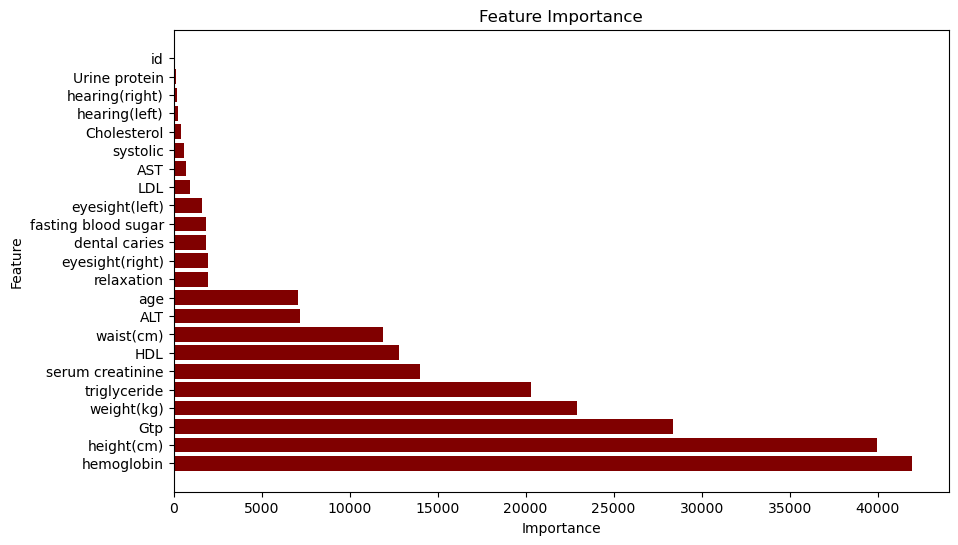

In [37]:
importances_df = pd.DataFrame({'Feature': train.iloc[:,:-1].columns, 'Importance': fit.scores_})
importances_df = importances_df.sort_values(by='Importance', ascending=False) # Sorting the DataFrame by importance in descending order

plt.figure(figsize=(10, 6) ,)
plt.barh(importances_df['Feature'], importances_df['Importance'] , color = 'Maroon')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

In [39]:
column=[
    'Urine protein',
    'hearing(right)',
    'hearing(left)',
    'Cholesterol',
    'systolic',
    'AST',
    'LDL',
    'eyesight(left)',
    'fasting blood sugar',
    'dental caries',
    'eyesight(right)',
    'relaxation',
    'age',
    'ALT'
]
test.drop(columns=column,inplace=True)
train.drop(columns=column,inplace=True)

# 4. Models

#### Spliting Train Data

In [41]:
# Assigning classification variable to y and rest
y = train.smoking
X = train.drop(columns=['id', 'smoking'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17, shuffle=True)


In [42]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((111479, 8), (47777, 8), (111479,), (47777,))

### RandomForest

In [93]:
random_forest_model = RandomForestClassifier(
    n_estimators=300,       # Number of trees in the forest       
    criterion='gini',      
    max_depth=10,           # Maximum depth of the tree    
    min_samples_split=3,    
    min_samples_leaf=4,     
    random_state=15,        # Seed for random number generation for reproducibility
    max_features='log2',    # Maximum number of features to consider for a split
    class_weight='balanced' # Weights associated with classes to handle class imbalance
)
random_forest_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       max_features='log2', min_samples_leaf=4,
                       min_samples_split=3, n_estimators=300, random_state=15)

In [94]:
y_pred2 = random_forest_model.predict_proba(X_test)[:,1]

roc_auc = roc_auc_score(y_test, y_pred2)
print("ROC AUC Score:", roc_auc)

ROC AUC Score: 0.8435490452458109


#### Final Predictions

In [97]:
df_test_copy = test.copy()
df_test_copy = df_test_copy.drop(columns=['id'],axis=1)
predictions=random_forest_model.predict_proba(df_test_copy)[:,1]
print(predictions)

[0.714237   0.40074222 0.66398542 ... 0.52392681 0.15786034 0.03056044]


# 5. Submissions

In [1]:
sub = pd.read_csv('/kaggle/input/playground-series-s3e24/sample_submission.csv')
sub['smoking'] =  predictions
sub.to_csv('submission_pure.csv',index=False)
sub.head()


KeyboardInterrupt

